In [0]:
#%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import torch.utils.data as data_utils
#from utils import epoch, epoch_robust_bound, epoch_calculate_robust_err, Flatten, generate_kappa_schedule_CIFAR, generate_epsilon_schedule_CIFAR
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Utils and helper functions

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) 

In [0]:


def epoch(loader, model, device, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp,_ = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    bounds.append(initial_bound)
    list_of_layers = list(model.children())
    
    for i in range(len(list_of_layers)):
        layer = list_of_layers[i]
        
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)

        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
            
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model.last_linear.weight
    cb = c.t() @ model.last_linear.bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()


def epoch_robust_bound(loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse=False, opt=None):
    robust_err = 0
    total_robust_loss = 0
    total_mse_loss = 0
    total_ibp_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for i,data in enumerate(loader,0):
      
        #if i>299:  #calculate only for 100 batches
        #  break      
        
        mse_loss_list = []
        lower_bounds = []
        upper_bounds = []
        
        
        X,y = data
        X,y = X.to(device), y.to(device)
        
        ###### fit loss calculation ######
        yp,_ = model(X)
        fit_loss = nn.CrossEntropyLoss()(yp,y)
    
        ###### robust loss calculation ######
        initial_bound = (X - epsilon_schedule[batch_counter], X + epsilon_schedule[batch_counter])
        bounds = bound_propagation(model, initial_bound)
        robust_loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item() #increment when true label is not winning       
        
        total_robust_loss += robust_loss.item() * X.shape[0]  
        
        ##### MSE Loss #####
        
        indices_of_layers = [2,4,7,8] #CNN_small
        #indices_of_layers = [2,4,6,8,11,13,14] #CNN_medium
        
        
        for i in range(len(indices_of_layers)):
            lower_bounds.append(Flatten()(bounds[indices_of_layers[i]][0])) #lower bounds 
            upper_bounds.append(Flatten()(bounds[indices_of_layers[i]][1])) #upper bounds 
            mse_loss_list.append(nn.MSELoss()(lower_bounds[i], upper_bounds[i]))
            #mse_loss_list.append(RMSELoss(lower_bounds[i], upper_bounds[i]))
            #mse_loss_list.append(Log_Product_Loss(lower_bounds[i], upper_bounds[i]))
            #mse_loss_list.append(MAELoss(lower_bounds[i], upper_bounds[i]))
            #mse_loss_list.append(Log_Product_MAE(lower_bounds[i], upper_bounds[i]))
            
        
        mse_loss = mse_loss_list[0] + mse_loss_list[1] + mse_loss_list[2] #+ mse_loss_list[3] + mse_loss_list[4] + mse_loss_list[5] + mse_loss_list[6]
        total_mse_loss += mse_loss.item()
        
        ###### combined losss ######
        
        ibp_loss = kappa_schedule[batch_counter]*fit_loss + (1-kappa_schedule[batch_counter])*robust_loss
        
        if (mse==True): combined_loss =  ibp_loss + mse_loss
        else: combined_loss =  ibp_loss

        total_ibp_loss += ibp_loss.item()
        
        batch_counter +=1
         
        if opt:
            opt.zero_grad()
            combined_loss.backward()
            opt.step() 
        
    return robust_err / len(loader.dataset), total_ibp_loss / len(loader.dataset), total_mse_loss/ len(loader.dataset)

        
def epoch_calculate_robust_err (loader, model, epsilon, device):
    robust_err = 0.0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1


    for X,y in loader:
        X,y = X.to(device), y.to(device)
        
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)

        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)                
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item() #increment when true label is not winning       
        
    return robust_err / len(loader.dataset)
        
        


def generate_kappa_schedule_MNIST():

    kappa_schedule = 2000*[1] # warm-up phase
    kappa_value = 1.0
    step = 0.5/58000
    
    for i in range(58000):
        kappa_value = kappa_value - step
        kappa_schedule.append(kappa_value)
    
    return kappa_schedule

def generate_epsilon_schedule_MNIST(epsilon_train):
    
    epsilon_schedule = []
    step = epsilon_train/10000
            
    for i in range(10000):
        epsilon_schedule.append(i*step) #ramp-up phase
    
    for i in range(50000):
        epsilon_schedule.append(epsilon_train)
        
    return epsilon_schedule


def generate_kappa_schedule_CIFAR():

    kappa_schedule = 10000*[1] # warm-up phase
    kappa_value = 1.0
    step = 0.5/340000
    
    for i in range(340000):
        kappa_value = kappa_value - step
        kappa_schedule.append(kappa_value)
    
    return kappa_schedule

def generate_epsilon_schedule_CIFAR(epsilon_train):
    
    epsilon_schedule = []
      
    for i in range(350000):
      epsilon_schedule.append(epsilon_train)
        
    return epsilon_schedule 
  
  
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta)[0], y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta)[0],y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta


def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)[0]
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Loading dataset

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [0]:
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8243090.07it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135027.50it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2220189.35it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51324.56it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Model

In [0]:
class CNN_small(torch.nn.Module):
    def __init__(self):

        super(CNN_small, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.relu2 = nn.ReLU()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.relu3 = nn.ReLU()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):
        
        hidden_activations = []
        
        x = self.conv1(x)
        x = self.relu1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)

        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.relu3(x)

        
        out = self.last_linear(x)

        
        return out, hidden_activations

In [0]:
model = CNN_small().to(device)

# Training

In [0]:
EPSILON = 0.4
EPSILON_TRAIN = 0.4
kappa_schedule = generate_kappa_schedule_MNIST()

#let's change epsilon schedule to more dynamic
epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
  epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
  epsilon_schedule.append(EPSILON_TRAIN)

batch_counter = 0
filename1 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_IBP_test_error.txt'
ibp_test_error = []
filename2 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_IBP_verified_test_error.txt'
ibp_verified_test_error = []
filename3 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_IBP_mse_loss.txt'
ibp_mse_loss = []



mse = False
model = CNN_small().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

for t in range(50):
  _, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
  batch_counter += 600
  verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
  test_err,_ = epoch(test_loader, model, device)
  
  ibp_test_error.append(test_err)
  ibp_verified_test_error.append(verified)
  ibp_mse_loss.append(mse_loss)
  print (t)
  
np.savetxt(filename1, ibp_test_error)
np.savetxt(filename2, ibp_verified_test_error)
np.savetxt(filename3, ibp_mse_loss)

#############################################

batch_counter = 0
filename4 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_EXTRA_IBP_test_error.txt'
extra_ibp_test_error = []
filename5 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_EXTRA_IBP_verified_test_error.txt'
extra_ibp_verified_test_error = []
filename6 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_EXTRA_IBP_mse_loss.txt'
extra_ibp_mse_loss = []

mse = True
model = CNN_small().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

for t in range(50):
  _, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
  batch_counter += 600
  verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
  test_err,_ = epoch(test_loader, model, device)
  
  extra_ibp_test_error.append(test_err)
  extra_ibp_verified_test_error.append(verified)
  extra_ibp_mse_loss.append(mse_loss)
  print (t)
  
np.savetxt(filename4, extra_ibp_test_error)
np.savetxt(filename5, extra_ibp_verified_test_error)
np.savetxt(filename6, extra_ibp_mse_loss)

In [0]:
ibp_tab = []
filename1 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_IBP.txt'
ibp_tab = np.loadtxt(filename1)
filename2 = '/content/gdrive/My Drive/Colab Notebooks/results/stable_training_MNIST_extra_loss.txt'
extra_loss_tab = []
extra_loss_tab = np.loadtxt(filename2)

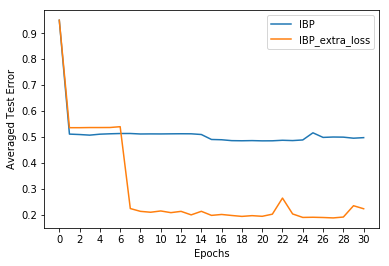

In [0]:
x  = [i for i in range(0,31)]

plt.plot(x,np.concatenate([[0.95],ibp_tab]), label="IBP")
plt.plot(x,np.concatenate([[0.95],extra_loss_tab]),  label="IBP_extra_loss")
plt.plot()
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.xlabel("Epochs")
plt.ylabel("Averaged Test Error")
plt.legend()
plt.show()